<a href="https://colab.research.google.com/github/funteck123/SUSAR_AI_Framework_Insight_Classfication_with_LLM_Text_Gen_Model-Python/blob/main/SUSAR_AI_Framework_Insight_Classfication_with_LLM_Text_Gen_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SUSAR AI Framework - Insight Classfication with LLM Text Gen Model** 🧠📔

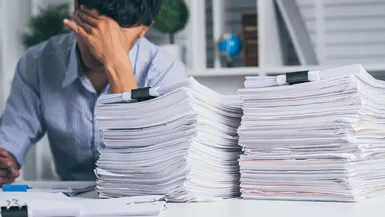

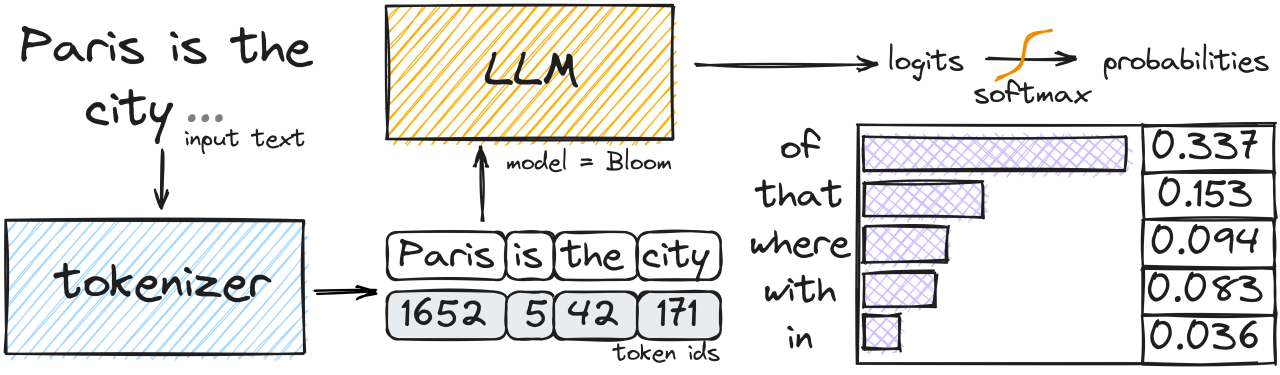

In [3]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, pipeline

# Load the Flan-T5-Large model and tokenizer
model_name = "google/flan-t5-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# Create a text generation pipeline with GPU support
generator = pipeline("text2text-generation", model=model, tokenizer=tokenizer, device=0)


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [91]:
# Patient Outcomes
patient_outcome_texts = [
    "The patient's clinical status shows incremental improvement with stable vital signs; however, full recovery remains elusive as evidenced by residual chronic symptoms and ongoing need for symptomatic treatment.",
    "Despite progressive therapeutic interventions, the patient exhibits persistent adverse reactions and secondary complications that impede recovery, necessitating advanced management strategies.",
    "Following an initial positive response to therapy, the patient has reached a plateau in health status with complete resolution of acute symptoms but ongoing subclinical indicators suggesting the necessity for prolonged observation.",
    "The patient's health trajectory demonstrates significant amelioration with the resolution of major disease symptoms, although minor residual effects warrant continued follow-up to confirm sustained recovery." ,
    "The patient's condition, initially responsive to treatment, has deteriorated leading to multi-organ failure, resulting in a deadly outcome."
]

# Correct outputs corresponding to the texts
patient_outcome_labels = [
    "Recovering",               # Incremental improvement but full recovery remains elusive
    "Not Recovering",  # Persistent adverse reactions and secondary complications impede recovery
    "Recovering",               # Plateau in health status with ongoing subclinical indicators
    "Recovering",               # Significant amelioration with resolution of major symptoms, minor residual effects
    "Fatal"                    # Deterioration leading to multi-organ failure and a deadly outcome
]


# Drug Actions
drug_action_texts_test = [
    "The dosage of the current medication was maintained following an assessment indicating stable clinical progress and minimal adverse events. Future evaluations will continue to monitor the necessity of any further dosage adjustments based on patient response.",    "The patient's recent adverse events are attributable to excessive drug exposure, prompting a dose reduction to mitigate toxicity while maintaining therapeutic benefits.",
    "Current therapeutic levels have stabilized the patient's condition; hence, no modification to the dosage is required as the medication remains within the therapeutic window.",
    "Due to the onset of severe side effects consistent with drug overdose, the medication regimen has been temporarily halted pending reassessment and dose adjustment.",
    "Emerging evidence from recent trials supports an escalation of the drug dosage to enhance therapeutic outcomes, with close monitoring for potential adverse effects during the increased dosage phase."
]

drug_action_labels_test = [
    "Same Dose",
    "Decrease",
    "Same Dose",
    "Stop",
    "Increase"
]

# Causalities
causality_texts_test = [
    "Analysis of the patient's symptomatology indicates that the observed side effects are consistent with known adverse reactions to the current medication, suggesting a direct causal relationship.",
    "The patient's clinical presentation correlates with a new, unrelated health condition, with no evidence linking the symptoms to the ongoing pharmacological treatment.",
    "The documented adverse effects are attributable to an interaction between the drug and an external factor, rather than a direct consequence of the medication itself.",
    "In-depth diagnostic evaluations reveal that the recent health complications are a direct result of the pharmacological intervention, corroborating a causative link between the drug and the symptoms.",
    "The occurrence of unexpected side effects aligns with a known complication profile for the drug, indicating that the medication is likely the primary factor contributing to the patient's symptoms."
]

causality_labels_test = [
    "Related",
    "Not Related",
    "Not Related",
    "Related",
    "Related"
]


In [92]:
def normalize_text(text):
    # Convert to lowercase, strip whitespace, and remove extra spaces
    return re.sub(r'\s+', ' ', text.strip().lower())

def evaluate_patient_outcomes(texts, correct_outputs):
    patient_outcomes = ["Not Recovering", "Recovering", "Recovering with Complications", "Recovered", "Fatal"]
    correct_predictions = 0
    total = len(texts)

    for i, text in enumerate(texts):
        # Detailed prompt for patient outcomes
        prompt = f"""
        You are provided with a description of a patient's health status. Your task is to classify the health status into one of the following categories based on the description provided:

        - Not Recovering: The patient is not showing signs of improvement and is not progressing towards recovery.
        - Recovering: The patient is in the process of improvement but has not yet fully recovered to a normal health state.
        - Recovering with Complications: The patient is in the recovery phase but is experiencing additional complications or health issues.
        - Recovered: The patient has fully recovered and returned to their normal state of health with negligible ongoing issues.
        - Fatal: The patient has passed away due to the condition or treatment.

        Description: {text}

        Based on the description, please assign the most appropriate label from the options: [Not Recovering, Recovering, Recovering with Complications, Recovered, Fatal]
        Label:
        """

        result = generator(prompt, max_length=150, num_return_sequences=1)
        generated_text = normalize_text(result[0]['generated_text'])

        # Normalize correct output
        correct_output = normalize_text(correct_outputs[i])

        if generated_text == correct_output:
            correct_predictions += 1
        else:
            print(f"Patient Outcome Text: {text}")
            print(f"Generated Text: {generated_text}")
            print(f"Correct Output: {correct_output}")
            print()

    accuracy = (correct_predictions / total) * 100
    return accuracy

def evaluate_drug_actions(texts, correct_outputs):
    drug_actions = ["Same Dose", "Stop", "Increase", "Decrease"]
    correct_predictions = 0
    total = len(texts)

    for i, text in enumerate(texts):
        # Detailed prompt for drug actions
        prompt = f"""
        Based on the description provided, identify the appropriate action related to the dosage of the drug. Choose one of the following options:

        - Same Dose: The dosage of the medication remains unchanged.
        - Stop: The drug administration is halted or discontinued.
        - Increase: The dosage of the medication is increased.
        - Decrease: The dosage of the medication is decreased.

        Description: {text}

        Assign the correct drug action from the options: [Same Dose, Stop, Increase, Decrease]
        Label:
        """

        result = generator(prompt, max_length=50, num_return_sequences=1)
        generated_text = normalize_text(result[0]['generated_text'])

        # Normalize correct output
        correct_output = normalize_text(correct_outputs[i])

        if generated_text == correct_output:
            correct_predictions += 1
        else:
            print(f"Drug Action Text: {text}")
            print(f"Generated Text: {generated_text}")
            print(f"Correct Output: {correct_output}")
            print()

    accuracy = (correct_predictions / total) * 100
    return accuracy

def evaluate_causalities(texts, correct_outputs):
    causalities = ["Related", "Not Related"]
    correct_predictions = 0
    total = len(texts)

    for i, text in enumerate(texts):
        # Detailed prompt for causalities
        prompt = f"""
        Based on the provided text, determine if the observed symptoms or issues are related to the drug treatment or not. Choose one of the following options:

        - Related: The symptoms or issues are connected to the drug or treatment.
        - Not Related: The symptoms or issues are not connected to the drug or treatment and may be due to other factors.

        Description: {text}

        Assign the correct causality label from the options: [Related, Not Related]
        Label:
        """

        result = generator(prompt, max_length=50, num_return_sequences=1)
        generated_text = normalize_text(result[0]['generated_text'])

        # Normalize correct output
        correct_output = normalize_text(correct_outputs[i])

        if generated_text == correct_output:
            correct_predictions += 1
        else:
            print(f"Causality Text: {text}")
            print(f"Generated Text: {generated_text}")
            print(f"Correct Output: {correct_output}")
            print()

    accuracy = (correct_predictions / total) * 100
    return accuracy

In [93]:
# Evaluate the model
patient_outcome_accuracy = evaluate_patient_outcomes(patient_outcome_texts, patient_outcome_labels)
print(f"Patient Outcome Accuracy: {patient_outcome_accuracy:.2f}%")

drug_action_accuracy = evaluate_drug_actions(drug_action_texts, drug_action_labels)
print(f"Drug Action Accuracy: {drug_action_accuracy:.2f}%")

causality_accuracy = evaluate_causalities(causality_texts, causality_labels)
print(f"Causality Accuracy: {causality_accuracy:.2f}%")

Patient Outcome Accuracy: 100.00%
Drug Action Accuracy: 100.00%
Causality Accuracy: 100.00%
